In [28]:
# standard library
import logging
import os
from pathlib import Path    
import sys

# third-party packages
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# notebook
from IPython import display

# get absolute path to file's parent directory
dir_proj_base = Path(os.getcwd()).resolve().parents[1]
sys.path.insert(0, f"{dir_proj_base}/src")

# Internal dependencies
from utils.figure_style import set_style  # noqa: E402

In [2]:
# notebook logger has DEBUG level
log = logging.getLogger("dipole_moment_notebook")
log.setLevel(logging.DEBUG)

# console handler
format = logging.Formatter("%(asctime)s - %(name)s - %(levelname)s - %(message)s")
ch = logging.StreamHandler(sys.stdout)
ch.setFormatter(format)
log.addHandler(ch)

In [3]:
# set plotting style
set_style()

In [17]:
# set thermal energy
TEMPERATURE_K: float = 300  # [K] # system temperature
KB = 8.314462618e-3  # [kJ/mol/K]
kbt = KB * TEMPERATURE_K  # [kJ/mol]

In [11]:
def plumed_df(file: Path) -> pd.DataFrame:
    # input checking
    if not file.exists():
        log.error(f"File {file} does not exist")
        sys.exit(1)

    # first line of file contains column names
    with open(str(file), encoding="utf8") as f:
        header = f.readline()
    header = header.split()[2:]  # remove "#!" FIELDS
    n_cols = len(header)

    # read in data
    df = pd.read_csv(
        str(file),
        names=header,
        comment="#",
        delim_whitespace=True,
        skipinitialspace=True,
        usecols=list(range(n_cols)),
    )
    return df


In [12]:
n_ca = 0
data_dir = Path(f"/home/aglisman/VSCodeProjects/Polyelectrolyte-Surface-Adsorption/data/sjobid_0-calcite-104surface-12nm_surface-13nm_vertical-1chain-PAcr-32mer-{n_ca}Crb-0Ca-32Na-0Cl-300K-1bar-NVT/3-sampling-opes-explore")
fname = "COLVAR.data"

# read in data
file = data_dir / fname
data = plumed_df(file)

In [15]:
data.head()

,time,dist_chain.x,dist_chain.y,dist_chain.z,opes.bias,opes.rct,opes.zed,opes.neff,opes.nker,opes.work,rg_chain,cn_ca_co,dist_ca.x,dist_ca.y,dist_ca.z,upper_wall.bias,upper_wall.force2,lower_wall.bias,lower_wall.force2
0,0.0,-9.251043,-0.241338,2.663596,-50.0,-50.0,1.0,1.0,0.0,0.0,1.880177,14.127018,-16.086862,22.071710,-3.743128,0.0,0.0,0.0,0.0
1,1.0,-9.258025,-0.240374,2.670805,-50.0,-50.0,1.0,1.0,0.0,0.0,1.866817,13.209399,-16.099294,22.071029,-3.743908,0.0,0.0,0.0,0.0
2,2.0,-9.259120,-0.255414,2.655282,-50.0,-50.0,1.0,1.0,0.0,0.0,1.864345,11.262444,-16.098069,21.876941,6.832931,0.0,0.0,0.0,0.0
3,3.0,-9.262654,-0.249217,2.669004,-50.0,-50.0,1.0,1.0,0.0,0.0,1.871892,10.825186,-16.118226,21.699721,-3.741085,0.0,0.0,0.0,0.0
4,4.0,-9.256982,-0.252319,2.655602,-50.0,-50.0,1.0,1.0,0.0,0.0,1.882240,10.892869,-16.114912,21.509838,6.843921,0.0,0.0,0.0,0.0


In [26]:
# print all column names
for col in data.columns:
    print(col)

log.info(f"Number of rows: {len(data)}")
log.info(f"Number of columns: {len(data.columns)}")

time
dist_chain.x
dist_chain.y
dist_chain.z
opes.bias
opes.rct
opes.zed
opes.neff
opes.nker
opes.work
rg_chain
cn_ca_co
dist_ca.x
dist_ca.y
dist_ca.z
upper_wall.bias
upper_wall.force2
lower_wall.bias
lower_wall.force2
bias
bias_nondim
weight
2023-09-26 14:38:43,998 - dipole_moment_notebook - INFO - Number of rows: 133681
2023-09-26 14:38:43,999 - dipole_moment_notebook - INFO - Number of columns: 22


In [27]:
# calculate overall bias
data["bias"] = data["opes.bias"] + data["upper_wall.bias"] + data["lower_wall.bias"]
data["bias_nondim"] = (data["bias"] - np.nanmax(data["bias"])) / kbt
data["weight"] = np.exp(data["bias_nondim"])
log.debug(f"(min, max) weight: ({np.nanmin(data['weight'])}, {np.nanmax(data['weight'])})")
log.debug(f"(0.25, 0.75) weight: ({np.nanpercentile(data['weight'], 25)}, {np.nanpercentile(data['weight'], 75)})")

2023-09-26 14:38:51,374 - dipole_moment_notebook - DEBUG - (min, max) weight: (7.721341978715541e-23, 1.0)
2023-09-26 14:38:51,377 - dipole_moment_notebook - DEBUG - (0.25, 0.75) weight: (0.00020990472801271266, 0.31410790142637207)


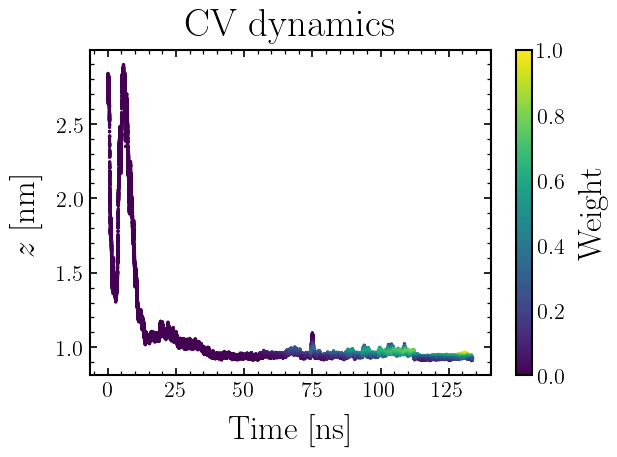

In [43]:
# plot the dynamics of the cv
cv = "dist_chain.z"

fig = plt.figure()
ax = fig.add_subplot(111)

sc = ax.scatter(data["time"]/1e3, data[cv], s=2, c=data["weight"], cmap="viridis")
ax.set_xlabel("Time [ns]", labelpad=10)
ax.set_ylabel("$z$ [nm]", labelpad=10)
ax.set_title("CV dynamics", pad=10)

# add colorbar
cbar = plt.colorbar(sc)
cbar.set_label("Weight", labelpad=10)


fig.tight_layout()



In [ ]:
def fes_dist(x: np.ndarray, w: np.ndarray = None) -> tuple[np.ndarray, np.ndarray]:
    """Calculate the free energy surface for a given distance collective variable.

    Parameters
    ----------
    x : np.ndarray
        Array of distances.
    w : np.ndarray, optional
        Array of weights, by default None
    
    Returns
    -------
    tuple[np.ndarray, np.ndarray]
        Tuple of arrays of distances and free energies.
    """
